In [ ]:
#!pip uninstall tensorflow
#!pip install tensorflow
#!pip uninstall tensorflow
#!pip install tensorflow

In [ ]:
!python --version
!pip list
!pip freeze > requirements.txt

Python 3.10.12
Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
aiohttp                          3.9.5
aiosignal                        1.3.1
alabaster                        0.7.16
albumentations                   1.3.1
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.15.1
astropy                          5.3.4
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            23.2.0
audioread                        3.0.1
autograd                         1.6.2
Babel                            2.15.0
backcall                         0.2.0
beautifulsoup4                   4.12.3
bidict                  

In [ ]:
from google.colab import drive
# Google Colabを使用する場合のドライブマウント
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
from datetime import datetime
from pathlib import Path
import zipfile

import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import keras
from keras.applications.vgg16 import VGG16
from keras.applications import MobileNetV2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Input, GlobalAveragePooling2D
from keras.models import Sequential
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

def load_images_from_folder(folder_path: Path) -> np.ndarray:
    """
    指定されたフォルダから画像を読み込み、Numpy配列として返す

    Parameters:
        folder_path (Path): 画像フォルダへのパス

    Returns:
        np.ndarray: 画像データ配列
    """
    file_list = [filename for filename in os.listdir(str(folder_path)) if not filename.startswith('.')]
    result_list: list = []

    for file_name in file_list:
        file_path: Path = folder_path / file_name
        # cv2.imreadは、指定されたファイルパスから画像を読み込み、BGR（青、緑、赤）形式のNumpy配列として返す。形状は(高さ(行), 幅(列), チャネル数3)となる
        original_image: np.ndarray = cv2.imread(str(file_path))

        if original_image is None:
            print(f"画像の読み込みに失敗しました: {file_name}")
            continue
        # 画像をリストに追加
        result_list.append(original_image)
    # リストをNumpy配列に変換して返す
    return np.array(result_list)

def unzip_file(zip_file_path: Path, folder_to_extract_zip_file: Path):
    """
    zipを解凍する

    Args:
        zip_file_path (Path): 解凍するzipファイルパス
        folder_to_extract_zip_file (Path): zipファイルを展開するフォルダー

    """
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(folder_to_extract_zip_file)
        print(f"Files extracted to {folder_to_extract_zip_file}")
    except zipfile.BadZipFile:
        print(f"Error: {zip_file_path} is not a valid zip file.")
    except Exception as e:
        print(f"An error occurred: {e}")

def normalize_image_data(images) -> np.ndarray:
    """
    画像データを正規化し、NumPy配列として返す
    画像データは最小値が0、最大値が255なので、255で割り、0から1の範囲に変換する

    Args:
        images (list[np.ndarray]): 画像データのリスト

    Returns:
        np.ndarray: 正規化された画像データの配列
    """
    processed_images = []
    for img in images:
        img = img / 255.0
        processed_images.append(img)
    return np.array(processed_images)



In [ ]:
def build_model(input_shape: tuple) -> keras.src.engine.sequential.Sequential:
    """
    VGG16ベースの転移学習モデルを構築する

    この関数は、VGG16モデルをベースにした転移学習モデルを構築し、最終的な分類層を追加します。
    VGG16の事前訓練済みの重みを使用し、カスタムの全結合層とドロップアウト層を追加して、特定のタスクに適応させます。

    Args:
        input_shape (tuple): モデルに入力される画像の形状 (height, width, channels)

    Returns:
        keras.src.engine.sequential.Sequential: 構築されたKerasのSequentialモデル
    """
    vgg16: keras.src.engine.functional.Functional = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    model: keras.src.engine.sequential.Sequential = Sequential([
        vgg16,
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax') # 合計値1になるように値を振り分ける (70, 20, 10) ⇒ (0.7, 0.2, 0.1)
    ])

    for layer in vgg16.layers:
        layer.trainable = False

    model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print(f"build_model model : {type(model)}")

    return model

def build_model_light(input_shape: tuple) -> keras.Sequential:
    """
    MobileNetV2ベースの転移学習モデルを構築する

    この関数は、MobileNetV2モデルをベースにした転移学習モデルを構築し、最終的な分類層を追加します。
    MobileNetV2の事前訓練済みの重みを使用し、カスタムの全結合層とドロップアウト層を追加して、特定のタスクに適応させます。

    Args:
        input_shape (tuple): モデルに入力される画像の形状 (height, width, channels)

    Returns:
        keras.Sequential: 構築されたKerasのSequentialモデル
    """
    mobilenet_v2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)

    model = Sequential([
        mobilenet_v2,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),  # ユニット数を削減
        Dropout(0.5),
        Dense(3, activation='softmax')  # 合計値1になるように値を振り分ける (70, 20, 10) ⇒ (0.7, 0.2, 0.1)
    ])

    for layer in mobilenet_v2.layers:
        layer.trainable = False

    model.compile(optimizer=SGD(learning_rate=0.001, momentum=0.9),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    print(f"build_model model : {type(model)}")

    return model

In [ ]:
def set_random_seed(seed: int):
    """
    指定されたシード値を使用して、乱数生成の再現性を設定する

    Args:
        seed (int): 乱数生成のシード値
    """
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def prepare_data(base_image_folder_path: Path, seed: int):
    """
    画像データをロードし、トレーニングセットとテストセットに分割する

    Args:
        base_image_folder_path (Path): 画像データが保存されているフォルダのパス
        seed (int): データ分割のランダムシード値

    Returns:
        X_train (np.ndarray): トレーニング用画像データのNumPy配列
        X_test (np.ndarray): テスト用画像データのNumPy配列
        y_train (np.ndarray): トレーニング用ラベルデータのワンホットエンコーディング配列
        y_test (np.ndarray): テスト用ラベルデータのワンホットエンコーディング配列
    """
    folder_path_pumpkin = base_image_folder_path / "pumpkin"
    folder_path_green_papper = base_image_folder_path / "green_papper"
    folder_path_tomato = base_image_folder_path / "tomato"

    pumpkin_images = load_images_from_folder(folder_path_pumpkin)
    green_papper_images = load_images_from_folder(folder_path_green_papper)
    tomato_images = load_images_from_folder(folder_path_tomato)

    print(f"pumpkin_images = {len(pumpkin_images)}")
    print(f"green_papper_images = {len(green_papper_images)}")
    print(f"tomato_images = {len(tomato_images)}")

    # 画像データを正規化する
    X_pumpkin = normalize_image_data(pumpkin_images)
    X_green_papper = normalize_image_data(green_papper_images)
    X_tomato = normalize_image_data(tomato_images)

    # すべての画像データを含むNumPy配列。形状は(総画像数, 画像高さ, 画像幅, チャネル数)
    X = np.concatenate([X_pumpkin, X_green_papper, X_tomato], axis=0)
    print(f"X shape : {X.shape}")

    # すべての画像に対応するラベルのリスト
    y = np.array([0]*len(pumpkin_images) + [1]*len(green_papper_images) + [2]*len(tomato_images))
    print(f"y shape : {y.shape}")

    # データをトレーニングセットとテストセットに分割
    X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.2, random_state=seed)

    # fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    # axes = axes.ravel()

    num_images_to_display = 30
    # 5行6列のサブプロットを作成
    fig, axes = plt.subplots(5, 6, figsize=(10, 10))

    # axesを1次元配列に変換
    axes = axes.ravel()

    for i in range(num_images_to_display):
        image = X_train[i][..., ::-1] # Ellipsis（...）を用いて、全行（高さ）と全列（幅）に対して、チャネルの順序を逆転する(BGR ⇒ RGB)
        axes[i].imshow(image) # 画像を表示
        axes[i].set_title( class_names[y_train[i]]) # 画像のクラス名をタイトルとして表示
        axes[i].axis('off') # 軸を非表示にする
    plt.show()


    # ワンホットエンコーディング
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=3)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=3)

    return X_train, X_test, y_train, y_test

In [ ]:
def plot_training_history(history: keras.callbacks.History):
    """
    トレーニング履歴から損失と精度のデータをプロットする

    Args:
            history (keras.callbacks.History): モデルのfitメソッドの戻り値であるトレーニング履歴オブジェクト
    """
    print(f"history.history : {history.history}")
    # loss : トレーニングデータの損失
    # accuracy : トレーニングデータの精度
    # val_loss : 検証データの損失 : (validatoin_splitを使用した場合)
    # val_accuracy : 検証データの精度 (validation_splitを使用した場合)
    print(f"history.params : {history.params}")


    plt.figure(figsize=(13, 4))  # 幅13インチ、高さ4インチの図を作成
    plt.subplots_adjust(wspace=0.5)  # サブプロット間の水平スペースを0.5inchに設定 グラフ間をあける設定

    # Lossの可視化
    plt.subplot(1, 2, 1) # 一行2列のうちの1番目のグラフ
    plt.plot(history.history["loss"], label="train") # 辞書でlossから50個分の値を取得してplot関数に渡す。ラベル(train)を追加
    plt.plot(history.history["val_loss"], label="valid")# 辞書でval_lossから50個分の値を取得してplot関数に渡す。ラベル(valid)を追加
    plt.title("Train and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Accuracyの可視化
    plt.subplot(1, 2, 2) # 一行2列のうちの2番目のグラフ
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="valid")
    plt.title("Train and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.show()

In [ ]:
# GPUの確認
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# 画像ファイルサイズ
image_file_size = 256
folder_path_to_extract_zip_file: Path = Path(f"/content/drive/MyDrive/images/plants_my_picture/")
zip_file_path: Path = folder_path_to_extract_zip_file / str(image_file_size)
base_image_folder_path: Path = Path(f"/content/drive/MyDrive/images/plants_my_picture/{image_file_size}/")
class_names = ["pumpkin", "green papper", "tomato"]

if not Path(base_image_folder_path).exists():
    # 展開フォルダーがない場合のみ解凍する
    zip_file_name = f"{image_file_size}.zip"
    zip_file_path = folder_path_to_extract_zip_file / zip_file_name
    print(f"folder_path_to_extract_zip_file = {folder_path_to_extract_zip_file}")
    print(f"zip_file_path = {zip_file_path}")
    print("test")
    unzip_file(zip_file_path, folder_path_to_extract_zip_file)

Num GPUs Available:  1


In [ ]:
# seed値を設定
seeds = [42, 52, 62]

# ハイパーパラメーターを設定
epochs = 50

histories: list[ keras.callbacks.History] = []

for seed in seeds:
    set_random_seed(seed)
    X_train, X_test, y_train, y_test = prepare_data(base_image_folder_path, seed)
    input_shape = (image_file_size, image_file_size, 3)
    model = build_model_light(input_shape)
    # モデルのトレーニングを実施する
    # 訓練データ : 学習させるデータ　(一部はヴァリデーションデータとして分ける)
    # test data : 学習させていないデータ (本当に何も使用していない未知画像データ)
    # validation data : 学習させていないデータ (モデルのハイパーパラメータがよいかどうかを評価する)(ハイパーパラメーターは人間が決める)(パラメーター(重み)は自動的に調整される)(ヴァリデーションデータよりもテストデータで検知できるようにしたい)
    # ハイパーパラメーター : epochs = 50, batch_size = 32
    history: keras.callbacks.History = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=32) # X_train(トレーニング用)からvalidation_splitとして0.2の割合で検証用の画像を取り出す (学習している画像以外のはじめての画像で検証する)
    histories.append(history)



Output hidden; open in https://colab.research.google.com to view.

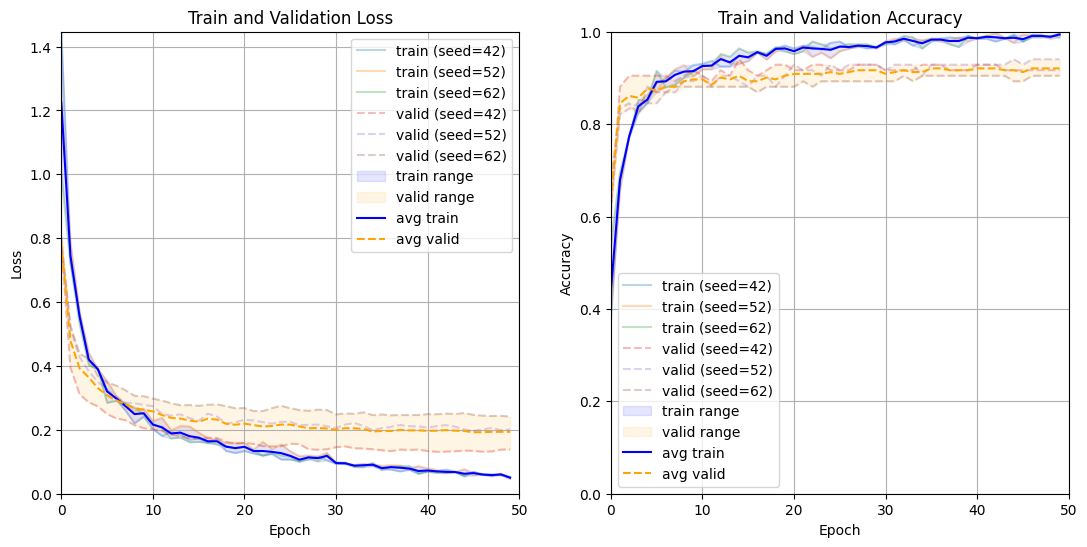

In [ ]:
def plot_histories_with_bands(seeds: list[int], histories: list[tf.keras.callbacks.History], epochs: int) -> None:
    """
    複数のトレーニング履歴を同じグラフにプロットし、最大・最小範囲を帯として表示する

    Args:
        seeds (list[int]): seed配列
        histories (list[keras.callbacks.History]): トレーニング履歴リスト
        epochs (int): エポック数
    """

    # NumPy配列に変換
    train_losses: np.ndarray = np.array([history.history['loss'] for history in histories])
    val_losses: np.ndarray = np.array([history.history['val_loss'] for history in histories])
    train_accuracies: np.ndarray = np.array([history.history['accuracy'] for history in histories])
    val_accuracies: np.ndarray = np.array([history.history['val_accuracy'] for history in histories])

    # 各列(エポック)ごとの最大値・最小値を計算
    max_train_loss: np.ndarray = train_losses.max(axis=0)
    min_train_loss: np.ndarray = train_losses.min(axis=0)
    max_val_loss: np.ndarray = val_losses.max(axis=0)
    min_val_loss: np.ndarray = val_losses.min(axis=0)
    max_train_acc: np.ndarray = train_accuracies.max(axis=0)
    min_train_acc: np.ndarray = train_accuracies.min(axis=0)
    max_val_acc: np.ndarray = val_accuracies.max(axis=0)
    min_val_acc: np.ndarray = val_accuracies.min(axis=0)

    # 各列(エポック)ごとの平均値を計算
    avg_train_loss: np.ndarray = train_losses.mean(axis=0)
    avg_val_loss: np.ndarray = val_losses.mean(axis=0)
    avg_train_acc: np.ndarray = train_accuracies.mean(axis=0)
    avg_val_acc: np.ndarray = val_accuracies.mean(axis=0)

    plt.figure(figsize=(13, 6))

    # Lossの可視化
    plt.subplot(1, 2, 1)

    # trainのlossを表示
    for seed, history in zip(seeds, histories):
        plt.plot(history.history["loss"], label=f"train (seed={seed})", alpha=0.3)
    # validのlossを表示
    for seed, history in zip(seeds, histories):
        plt.plot(history.history["val_loss"], label=f"valid (seed={seed})", linestyle='--', alpha=0.3)

    plt.fill_between(range(epochs), min_train_loss, max_train_loss, color='blue', alpha=0.1, label="train range")
    plt.fill_between(range(epochs), min_val_loss, max_val_loss, color='orange', alpha=0.1, label="valid range")
    plt.plot(avg_train_loss, color='blue', label="avg train")
    plt.plot(avg_val_loss, color='orange', linestyle='--', label="avg valid")

    # lossのy軸の範囲を設定
    max_loss_value = max(max_train_loss.max(), max_val_loss.max())

    plt.xlim(0, epochs)
    plt.ylim(0, max_loss_value)

    plt.title("Train and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()

    # Accuracyの可視化
    plt.subplot(1, 2, 2)

    # trainのaccuracyを表示
    for seed, history in zip(seeds, histories):
        plt.plot(history.history["accuracy"], label=f"train (seed={seed})", alpha=0.3)
    # validのaccracyを表示
    for seed, history in zip(seeds, histories):
        plt.plot(history.history["val_accuracy"], label=f"valid (seed={seed})", linestyle='--', alpha=0.3)

    plt.fill_between(range(epochs), min_train_acc, max_train_acc, color='blue', alpha=0.1, label="train range")
    plt.fill_between(range(epochs), min_val_acc, max_val_acc, color='orange', alpha=0.1, label="valid range")
    plt.plot(avg_train_acc, color='blue', label="avg train")
    plt.plot(avg_val_acc, color='orange', linestyle='--', label="avg valid")

    plt.xlim(0, epochs)
    plt.ylim(0, 1)

    plt.title("Train and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid()

    plt.show()

plot_histories_with_bands(seeds, histories, epochs)


In [ ]:
def predict_result_display(model: keras.src.engine.sequential.Sequential, images: np.ndarray, y_test: np.ndarray, class_names: list[str]):
    """
    モデルを使用して入力画像のクラス予測を行い、予測結果を表示する

    Args:
        model (keras.src.engine.sequential.Sequential): 予測に使用する訓練済みのKerasモデル
        images (np.ndarray): 予測するBGR形式の画像配列。形状は(num_images, height, width, channels)とすること
        y_test (np.ndarray): テスト用ラベルデータのワンホットエンコーディング配列
        class_names (list[str]): モデルが予測するクラスの名前のリスト

    Notes:
    - 入力画像はBGR形式で提供されるため、表示のためにRGB形式に変換すること
    """
    plt.figure(figsize=(12, 12)) # matplotlibの初期設定 (画像のサイズ(縦(12inch), 横(12inch)))
    for i in range(min(len(images), 30)):
        plt.subplot(5, 6, i + 1) # 図の分割 (plt.figureで定義したものをさらに5行5列で分割する)(通し番号(初期値はi+1=1))
        img_float32 = np.float32(images[i])
        plt.imshow(cv2.cvtColor(img_float32, cv2.COLOR_BGR2RGB)) # matplotlibはRGB形式にする必要がある。cv2はBGR形式で読み込む

        # predict image
        temp_img_array = img_float32.reshape(1, image_file_size, image_file_size, 3) # 次元を増やす(128, 128, 3(RGB)) ⇒ (1, 128, 128, 3(RGB)) バッチサイズ : 32枚まとめて学習
        # 2枚の場合は(2, 128, 128, 3)の場合となる
        img_pred: float = model.predict(temp_img_array) # 4次元に変換した画像データを1個入れてあげると予測値が出力される

        # 予測クラス名を取得
        predicted_class = class_names[np.argmax(img_pred)] # np.max: 大きい値を取り出す, np.argmax: 大きい値のインデックス番号を取り出す

        # 正解クラス名を取得
        true_class = class_names[np.argmax(y_test[i])]

        # 予測クラス名と正解クラス名を各サブプロットに表示する
        # 0.5: テキストのx座標。軸の中央に配置されます。
        # -0.2: テキストのy座標。画像の下に配置されます。
        # f"Pred: {predicted_class}\nTrue: {true_class}": 表示するテキスト。予測クラス名と正解クラス名が含まれます。
        # ha='center': テキストを中央揃えに設定します。
        # transform=plt.gca().transAxes: 軸の座標系に基づいてテキストを配置します。
        # fontsize=9: テキストのフォントサイズを9ポイントに設定します。
        plt.text(x = 0.5, y = -0.2, s = f"Pred: {predicted_class}\nTrue: {true_class}", ha='center', transform=plt.gca().transAxes, fontsize=9)  # 予測クラス名と正解クラス名をタイトルに表示
        plt.axis('off') # 縦軸・横軸を表示しない設定

    plt.subplots_adjust(hspace=0.5)  # 行間のスペースを設定
    plt.tight_layout() # レイアウトを調整
    plt.show() # グラフを表示

# 画像の予測結果を表示する
predict_result_display(model, X_test, y_test, class_names)




Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def summarize_final_results(seeds: list[int], histories: list[tf.keras.callbacks.History]) -> None:
    """
    各シード値でのトレーニングの最終結果を表示する

    Args:
        seeds (list[int]): seed配列
        histories (list[keras.callbacks.History]): トレーニング履歴リスト
    """

    # 最終エポックの結果を格納するリスト
    final_train_losses = []
    final_val_losses = []
    final_train_accuracies = []
    final_val_accuracies = []

    for history in histories:
        final_train_losses.append(history.history['loss'][-1])
        final_val_losses.append(history.history['val_loss'][-1])
        final_train_accuracies.append(history.history['accuracy'][-1])
        final_val_accuracies.append(history.history['val_accuracy'][-1])

    # 結果の表示
    print(f"{'Seed':^7} {'Train Loss':^12} {'Validation Loss':^18} {'Train Accuracy':^18} {'Validation Accuracy':^20}")
    print("="*75)
    for seed, train_loss, val_loss, train_acc, val_acc in zip(seeds, final_train_losses, final_val_losses, final_train_accuracies, final_val_accuracies):
        print(f"{seed:^7} {train_loss:^12.4f} {val_loss:^18.4f} {train_acc:^18.4f} {val_acc:^20.4f}")

    # 平均値の計算
    avg_train_loss = np.mean(final_train_losses)
    avg_val_loss = np.mean(final_val_losses)
    avg_train_acc = np.mean(final_train_accuracies)
    avg_val_acc = np.mean(final_val_accuracies)

    print("="*75)
    print(f"{'Average':^7} {avg_train_loss:^12.4f} {avg_val_loss:^18.4f} {avg_train_acc:^18.4f} {avg_val_acc:^20.4f}")


summarize_final_results(seeds, histories)

 Seed    Train Loss   Validation Loss     Train Accuracy   Validation Accuracy 
  42       0.0517          0.1387             0.9940              0.9167       
  52       0.0461          0.2013             1.0000              0.9405       
  62       0.0528          0.2415             0.9880              0.9048       
Average    0.0502          0.1938             0.9940              0.9206       


4/4 [==============================] - 0s 61ms/step


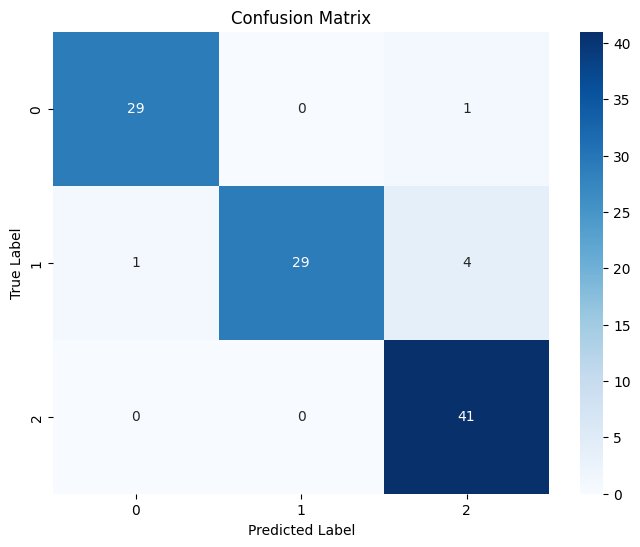

              precision    recall  f1-score   support

     pumpkin       0.97      0.97      0.97        30
green papper       1.00      0.85      0.92        34
      tomato       0.89      1.00      0.94        41

    accuracy                           0.94       105
   macro avg       0.95      0.94      0.94       105
weighted avg       0.95      0.94      0.94       105



In [ ]:
import seaborn as sns

def display_confusion_matrix_and_classification_report(model: Sequential, X_test: np.ndarray, y_test: np.ndarray, class_names: list[str]) -> None:
    """
    モデルの予測結果に基づいて混同行列と分類レポートを表示する

    Args:
        model (Sequential): 予測に使用する訓練済みのKerasモデル
        X_test (np.ndarray): テスト用の入力データ
        y_test (np.ndarray): テスト用ラベルデータのワンホットエンコーディング配列
        class_names (list[str]): モデルが予測するクラスの名前のリスト
    """
    # 予測結果の取得
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # 混同行列の計算
    conf_matrix = confusion_matrix(y_true, y_pred_classes)

    # 混同行列のプロット
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # 分類レポートの表示
    class_report = classification_report(y_true, y_pred_classes, target_names=class_names)
    print(class_report)

display_confusion_matrix_and_classification_report(model, X_test, y_test, class_names)

In [ ]:
# モデルを保存する
now = datetime.now()
timestamp = now.strftime("%Y%m%d_%H%M%S")
model_file_path: Path = Path(f'/content/drive/My Drive/my_model_{timestamp}.h5')
model.save(model_file_path)
file_size = model_file_path.stat().st_size
print(f"モデルファイルのサイズ: {(file_size / (1024 * 1024)):.2f} MB")


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


モデルファイルのサイズ: 10.20 MB


<keras.src.engine.input_layer.InputLayer object at 0x7f45513a32e0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f456dd91a80> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f44f8e043a0> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f44f8e3ded0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f44ddff5270> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f44f8e3dd50> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f44f8e3e3b0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f46048dde10> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f46048de4a0> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f44f8daa110> False
<keras.src.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f44ddfd9c00> False
<keras.src.layers.convolutional.conv2d.Conv2D object at 0x7f44ddfda260> False
<keras.src.layers.convolutional.conv2d.Conv2D ob

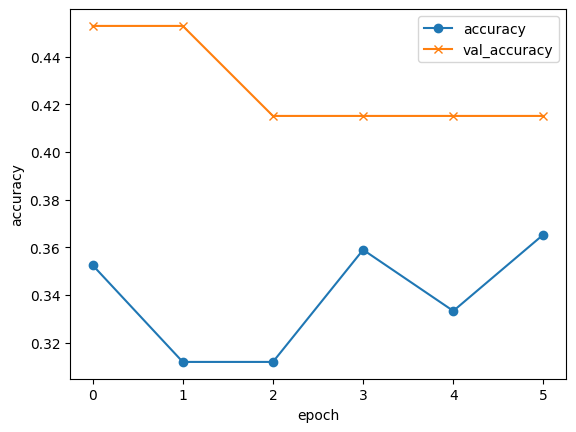

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:



# # # ラベルの作成
# # y_pumpkin = [0] * len(X_pumpkin)
# # y_green_papper = [1] * len(X_green_papper)
# # y_tomato = [2] * len(X_tomato)

# # # データの結合
# # X = np.concatenate([X_pumpkin, X_green_papper, X_tomato], axis=0)
# # y = np.concatenate([y_pumpkin, y_green_papper, y_tomato], axis=0)

# # # データのシャッフルと分割
# # X, y = shuffle(X, y)
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


# # # 正解ラベルをone-hotベクトルで求める
# # # to_categorical 関数を使用して、正解ラベル (y_train, y_test) をone-hotエンコーディングします。これにより、各ラベルが0または1のベクトルに変換されます。
# # y_train = to_categorical(y_train, num_classes=3)
# # y_test = to_categorical(y_test, num_classes=3)

# # # データ拡張の設定
# # datagen = ImageDataGenerator(
# #     rotation_range=20,      # 20度までランダムに回転
# #     width_shift_range=0.2,  # 画像を20%までランダムに左右にシフト
# #     height_shift_range=0.2, # 画像を20%までランダムに上下にシフト
# #     shear_range=0.2,        # ランダムにせん断
# #     zoom_range=0.2,         # ランダムにズーム
# #     horizontal_flip=True,   # ランダムに水平反転
# #     brightness_range=[0.8, 1.2],  # 明るさの変更を追加
# #     fill_mode='nearest'     # 新しいピクセルは最も近いピクセルの値で埋める
# # )


# # input_tensor として、学習する画像データの形状を定義しています。
# # image_resize_size はリサイズ後の画像のサイズを示しており、ここでは (image_height, image_width, 3) となります。
# # これは、高さXピクセル、幅Yピクセル、RGBチャンネル（3チャンネル）を持つ画像データをモデルに入力することを意味します。
# input_shape = Input(shape=(image_height, image_width, 3))

# # 転移学習のモデルとしてVGG16を使用
# vgg16_base = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)


# # VGG16の上から15層分を固定して、学習させないようにする。
# # 最下層4層分については再学習させる
# for layer in vgg16_base.layers[:15]:
#     layer.trainable = False

# # VGG16の各層の重みの固定状況を確認する
# for layer in vgg16_base.layers:
#     print(layer, layer.trainable)

# # vgg16の構造を確認する
# print(f"vgg16_base layer count : {len(vgg16_base.layers)}")
# vgg16_base.summary()

# # 転移学習モデルの構造を確認する
# print(f"model layer count : {len(model.layers)}")
# model.summary()

# # 訓練されるパラメーターの確認
# for layer in model.layers:
#     print(layer, layer.trainable )

# print(len(model.trainable_weights))


# # モデルのコンパイル
# model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# # チェックポイントコールバックの設定
# checkpoint = ModelCheckpoint('model_checkpoint.h5', save_best_only=True, save_weights_only=True)
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
# # monitor : 検証損失（val_loss）を監視します。検証損失が改善しない場合に、学習率を減少させるトリガーとします。
# # factor : 現在の学習率の20%に減少させます。例えば、現在の学習率が0.001の場合、新しい学習率は0.0002になります
# # patience : 検証損失が3エポック連続で改善しない場合に、学習率を減少させます
# # min_lr : 学習率の最小値を0.00001に設定します。これ以上学習率が減少しないようにします

# # モデルの学習（GPUを使用）
# with tf.device('/GPU:0'):
#     history = model.fit(
#         datagen.flow(X_train, y_train, batch_size=32),
#         batch_size=32,
#         epochs=50,
#         validation_data=(X_test, y_test),
#         callbacks=[checkpoint, early_stopping, reduce_lr]
#     )


# # validationがあったほうがよい。(なくても現状はよい)
# # クイックに検証できるvalidationがあるといい (train_test_splitで新たに追加する)
# # 画像が少ない状態で精度が上がらないのに、画像を増やしてもあまり効果はない
# # 画像が増やせれば、汎化性能が上がる。(学習時に来ない画像が来る)

# # テスト時(val_accracyが上がらないとデータ拡張は必要)
# # クラスに偏りがあるとかがくしゅうが発生してしまう

# # 学習の精度があげるためには
# #・画像サイズは大きくすれば、精度が上がりやすい
# #・モデルの定義検証(モデルを最も簡単にする(ドロップアウトを削るなど)してから、複雑にすることを検証する) (優先度②)
# #・ランダムシード tensorflowの固定化 (ランダムシート3個で実験して平均をとる)(統計的に有利になる) (優先度①) (ランダムシートは必ず固定化する)
# # plot_between_lineで最大、最小、中間で、matplotlibで表現することが可能
# # ⇒・ミニバッチファイルはランダムシードの影響を受ける (再現性がなくなる)


# # 検証データで評価
# score = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
# print('Validation loss: {0[0]}\nValidation accuracy: {0[1]}'.format(score))

# # 正解率と検証用の正解率をプロット
# plt.plot(history.history["accuracy"], label="accuracy", ls="-", marker="o")
# plt.plot(history.history["val_accuracy"], label="val_accuracy", ls="-", marker="x")
# plt.ylabel("accuracy")
# plt.xlabel("epoch")
# plt.legend(loc="best")
# plt.show()

# # モデルを保存
# # Google Driveの特定のディレクトリにモデルを保存
# # 現在の日時を取得
# now = datetime.now()
# timestamp = now.strftime("%Y%m%d_%H%M%S")
# model_filename = f'/content/drive/My Drive/my_model_{timestamp}.h5'
# model.save(model_filename)


2/2 [==============================] - 0s 56ms/step


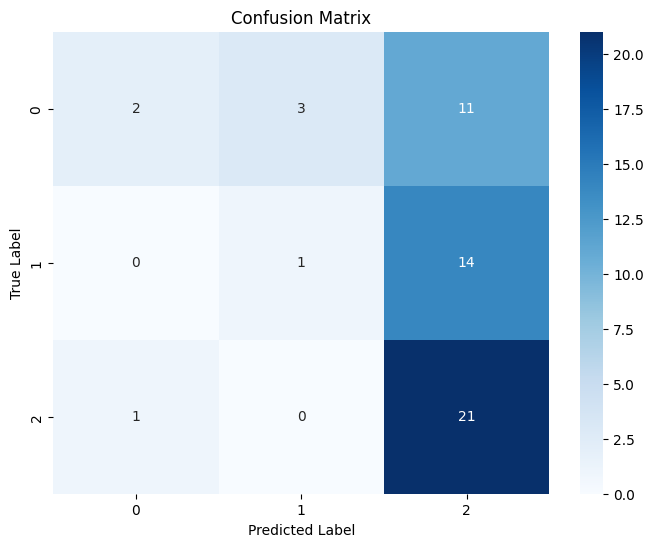

              precision    recall  f1-score   support

     Pumpkin       0.67      0.12      0.21        16
Green Pepper       0.25      0.07      0.11        15
      Tomato       0.46      0.95      0.62        22

    accuracy                           0.45        53
   macro avg       0.46      0.38      0.31        53
weighted avg       0.46      0.45      0.35        53



In [ ]:
import seaborn as sns
# 混同行列と分類レポートの表示
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

class_report = classification_report(y_true, y_pred_classes, target_names=['Pumpkin', 'Green Pepper', 'Tomato'])
print(class_report)

In [ ]:
# 早期停止:

# 以下のようにデータ拡張のパラメータを工夫して設定することができます：
# datagen = ImageDataGenerator(
#     rotation_range=30,         # 30度までランダムに回転
#     width_shift_range=0.3,     # 画像を30%までランダムに左右にシフト
#     height_shift_range=0.3,    # 画像を30%までランダムに上下にシフト
#     shear_range=0.3,           # ランダムにせん断
#     zoom_range=0.3,            # ランダムにズーム
#     horizontal_flip=True,      # ランダムに水平反転
#     brightness_range=[0.7, 1.3], # 明るさの範囲を指定
#     fill_mode='nearest'        # 新しいピクセルは最も近いピクセルの値で埋める
# )

In [ ]:
#早期停止:

#早期停止(Early Stopping)を導入することで、過学習を防ぎ、最適なエポックで学習を終了することができます。例えば、以下のようにtf.keras.callbacks.EarlyStoppingを使用します。

# from tensorflow.keras.callbacks import EarlyStopping

# early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# history = model.fit(
#     datagen.flow(X_train, y_train, batch_size=32),
#     epochs=50,
#     validation_data=(X_test, y_test),
#     callbacks=[early_stopping]
# )

In [ ]:
# 学習率の調整:
# 学習率を動的に調整することで、学習の効率を向上させることができます。例えば、tf.keras.callbacks.ReduceLROnPlateauを使用して、学習が停滞した場合に学習率を下げることができます。
# from tensorflow.keras.callbacks import ReduceLROnPlateau

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# history = model.fit(
#     datagen.flow(X_train, y_train, batch_size=32),
#     epochs=50,
#     validation_data=(X_test, y_test),
#     callbacks=[reduce_lr]
# )

In [ ]:
#モデルのアーキテクチャの微調整:

#現在のモデル構造がうまく機能しない場合は、Dense層のユニット数やDropoutの割合を調整してみると良いでしょう。また、異なるベースモデル（例えば、ResNetやInceptionなど）を試すことも有効です。

In [ ]:
# TensorFlow/Kerasの公式ドキュメント: 最新のAPIや機能について学ぶために役立ちます。
# オンラインコースやチュートリアル: 深層学習や転移学習の具体的なケーススタディを通じて理解を深めることができます。
# 学術論文: 最先端の研究成果や新しいアプローチを知るために有用です。